In [10]:
from google.cloud import bigquery
from google.cloud import bigquery_storage
import pandas as pd
import matplotlib.pyplot as plt

client = bigquery.Client()
bqstorage_client = bigquery_storage.BigQueryReadClient()

In [11]:

# Create BigQuery Storage client
query = """
SELECT *
FROM `bigquery-public-data.iowa_liquor_sales.sales`
WHERE date <= '2023-03-31' and date >= '2023-01-01'
"""

df = client.query(query).to_dataframe(bqstorage_client=bqstorage_client)

# Display results
df.head()

,invoice_and_item_number,date,store_number,store_name,address,city,zip_code,store_location,county_number,county,...,item_number,item_description,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons
0,RINV-04572100044,2023-03-28,6345,ROUND WINDOW LIQUOR / KNOXVILLE,701 WEST PLEASANT STREET,KNOXVILLE,50138,POINT(-93.10565 41.32074),None,MARION,...,19064,JIM BEAM,24,375,5.60,8.40,-24,-201.60,-9.00,-2.37
1,RINV-04457500325,2023-01-11,2538,HY-VEE FOOD STORE #3 (1866) / WATERLOO,1422 FLAMMANG DR,WATERLOO,50702,POINT(-92.32789 42.45998),None,BLACK HAWK,...,53214,PAUL MASSON GRANDE AMBER BRANDY VS,24,375,3.22,4.83,-24,-115.92,-9.00,-2.37
2,RINV-04471100032,2023-01-20,5149,B S MINI MART INC,"1900, SUMMER ST",BURLINGTON,52601,POINT(-91.11612 40.78899),None,DES MOINES,...,83370,ICE HOLE MINT SCHNAPPS,12,750,5.15,7.73,-12,-92.76,-9.00,-2.37
3,INV-57143700002,2023-03-31,2618,HY-VEE DRUGSTORE #6 / CEDAR RAPIDS,505 BOYSON RD NE,CEDAR RAPIDS,52402,POINT(-91.63912 42.04672),None,LINN,...,11771,BLACK VELVET MINI,8,50,8.87,13.31,1,13.31,0.05,0.01
4,INV-56992400002,2023-03-27,4967,JEFF'S MARKET / BLUE GRASS,"102, W MAYNE ST",BLUE GRASS,52726,POINT(-90.7661 41.50912),None,SCOTT,...,11771,BLACK VELVET MINI,8,50,8.87,13.31,1,13.31,0.05,0.01


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 624100 entries, 0 to 624099
Data columns (total 24 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   invoice_and_item_number  624100 non-null  object 
 1   date                     624100 non-null  dbdate 
 2   store_number             624100 non-null  object 
 3   store_name               624100 non-null  object 
 4   address                  623386 non-null  object 
 5   city                     623386 non-null  object 
 6   zip_code                 623386 non-null  object 
 7   store_location           608433 non-null  object 
 8   county_number            0 non-null       object 
 9   county                   623386 non-null  object 
 10  category                 624100 non-null  object 
 11  category_name            624100 non-null  object 
 12  vendor_number            624100 non-null  object 
 13  vendor_name              624100 non-null  object 
 14  item

In [14]:
# SQL query to get the top bottle types per city
query = """
SELECT 
    city,
    category_name AS bottle_type,
    SUM(bottles_sold) AS total_bottles_sold
FROM `bigquery-public-data.iowa_liquor_sales.sales`
WHERE date BETWEEN '2023-01-01' AND '2023-03-31'
GROUP BY city, category_name
QUALIFY ROW_NUMBER() OVER (PARTITION BY city ORDER BY SUM(bottles_sold) DESC) = 1
ORDER BY total_bottles_sold DESC
LIMIT 10
"""

In [15]:
df = client.query(query).to_dataframe(bqstorage_client=bqstorage_client)

# Display the results
print(df.to_string(index=False))


           city     bottle_type  total_bottles_sold
     DES MOINES AMERICAN VODKAS              178565
   CEDAR RAPIDS AMERICAN VODKAS              108598
      DAVENPORT AMERICAN VODKAS               90418
      IOWA CITY AMERICAN VODKAS               54207
 COUNCIL BLUFFS WHISKEY LIQUEUR               53728
       WATERLOO AMERICAN VODKAS               50894
WEST DES MOINES AMERICAN VODKAS               48761
     SIOUX CITY WHISKEY LIQUEUR               43227
        DUBUQUE AMERICAN VODKAS               42392
         ANKENY AMERICAN VODKAS               33003


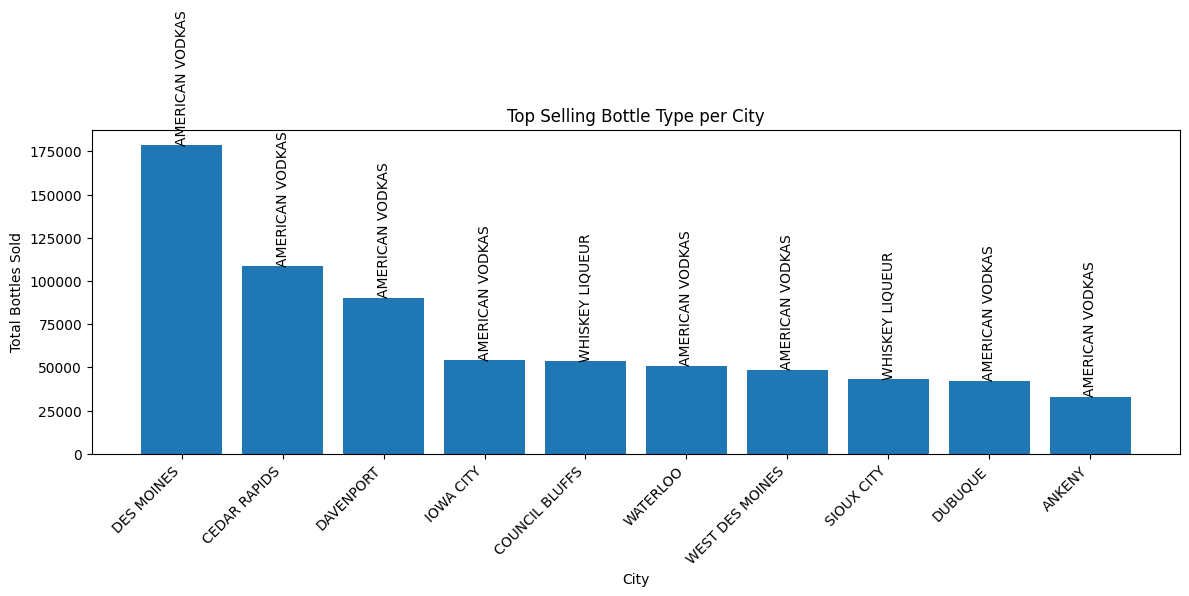

In [16]:
plt.figure(figsize=(12, 6))
plt.bar(df['city'], df['total_bottles_sold'])
plt.xticks(rotation=45, ha='right')
plt.xlabel('City')
plt.ylabel('Total Bottles Sold')
plt.title('Top Selling Bottle Type per City')
for i, v in enumerate(df['total_bottles_sold']):
    plt.text(i, v, df['bottle_type'].iloc[i], ha='center', va='bottom', rotation=90)
plt.tight_layout()
plt.show()


In [17]:
#top stores per city 
query = """
SELECT 
    city,
    store_name,
    SUM(bottles_sold) AS total_bottles_sold
FROM `bigquery-public-data.iowa_liquor_sales.sales`
WHERE date BETWEEN '2023-01-01' AND '2023-03-31'
GROUP BY city, store_name
QUALIFY ROW_NUMBER() OVER (PARTITION BY city ORDER BY SUM(bottles_sold) DESC) = 1
ORDER BY total_bottles_sold DESC
LIMIT 10
"""

In [18]:
df = client.query(query).to_dataframe(bqstorage_client=bqstorage_client)

# Display the results
print(df.to_string(index=False))

           city                                    store_name  total_bottles_sold
     DES MOINES                  HY-VEE #3 / BDI / DES MOINES              200027
      IOWA CITY HY-VEE WINE AND SPIRITS #1 (1281) / IOWA CITY               92426
         DEWITT                        ANOTHER ROUND / DEWITT               80715
   CEDAR RAPIDS                             BENZ DISTRIBUTING               65571
   MOUNT VERNON                                WILKIE LIQUORS               56210
 COUNCIL BLUFFS                  I-80 LIQUOR / COUNCIL BLUFFS               43724
WINDSOR HEIGHTS             SAM'S CLUB 6344 / WINDSOR HEIGHTS               37565
       WATERLOO                    SAM'S CLUB 6514 / WATERLOO               32019
     CORALVILLE                HY-VEE FOOD STORE / CORALVILLE               31830
     SIOUX CITY                  SAM'S CLUB 6432 / SIOUX CITY               31434


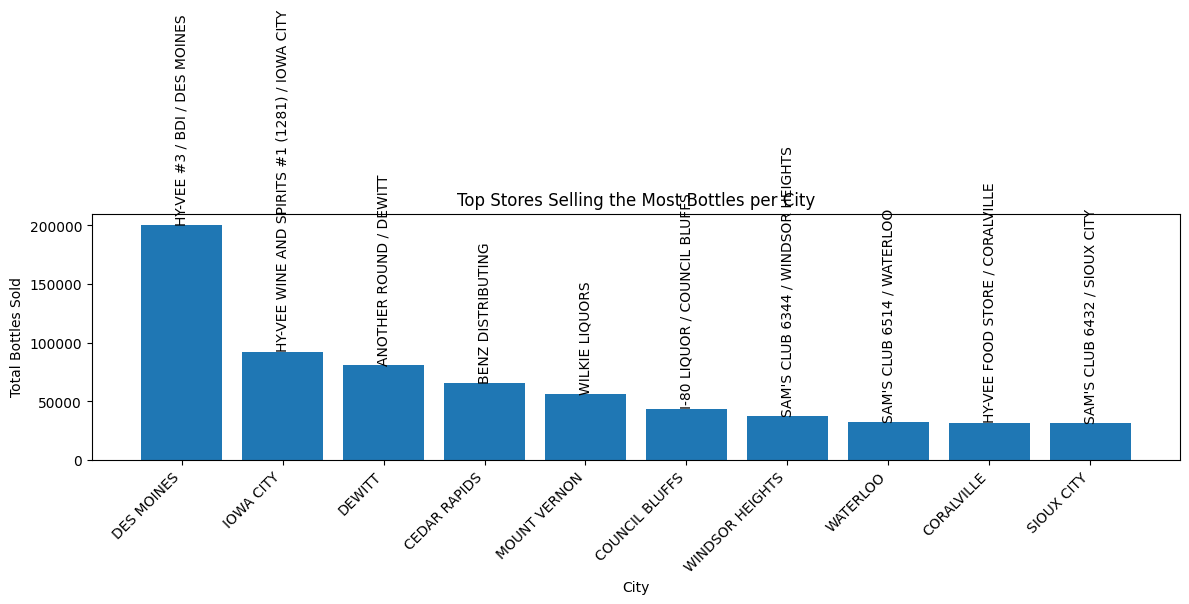

In [19]:
plt.figure(figsize=(12, 6))
plt.bar(df['city'], df['total_bottles_sold'])
plt.xticks(rotation=45, ha='right')
plt.xlabel('City')
plt.ylabel('Total Bottles Sold')
plt.title('Top Stores Selling the Most Bottles per City')
for i, v in enumerate(df['total_bottles_sold']):
    plt.text(i, v, df['store_name'].iloc[i], ha='center', va='bottom', rotation=90)
plt.tight_layout()
plt.show()